In [314]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display
import shap
from tqdm.notebook import tqdm

tf.random.set_seed(1234)

# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.


In [315]:
df = og_df.dropna(axis=1, how='all')
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

test_columns = pd.read_csv('baseline_feature_importance.csv', header=None, names=['feature','mae'])
test_columns = test_columns.iloc[1:20,0]
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)
first_column = df.pop('SE1')
test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]
dates = df.pop('Date')
df = df[test_columns]
print(df.columns)

  
df.insert(0, 'SE1', first_column)

# df = df.iloc[:,0:5]
print(df.shape)

n_features = df.shape[1]-1
print(n_features)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index(['Gas', 'Sveriges Förbrukning MWh', 'Summa Vindkraft',
       'Summa Vattenkraft', 'Summa kärnkraft', 'Summa Värmekraft',
       'Summa Ospecificerat', 'Summa Solkraft', 'Sveriges Produktion MWh',
       'Import/Export', 'Bioenergy and renewable waste', 'Biomass and biogas',
       'Differently categorized fossil fuels', 'Differently categorized hydro',
       'Differently categorized natural gas',
       'Differently categorized renewable energy sources',
       'Differently categorized solar', 'Differently categorized wind',
       'Fossil fuels'],
      dtype='object')
(202878, 20)
19


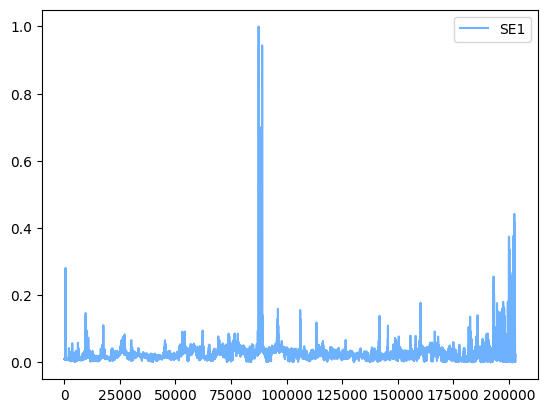

In [316]:
y = df['SE1']

plt.plot(y, color='#6db1ff', label='SE1')
plt.legend()

In [317]:

# Split the dataset into training and testing sets
test_size = int(len(df) * 0.05)
val_size = int(len(df) * 0.1)
val_end = test_end - test_size

train_df = df[:val_end-val_size]
val_df = df[val_end-val_size:val_end]
test_df = df[test_end-test_size:test_end]
train_df = pd.concat([train_df, df[test_end:]])

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(172448, 20)
(20287, 20)
(10143, 20)


In [318]:

train_df = train_df.to_numpy()
# print(train_df.shape)
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()
X_train = np.reshape(train_df[:,1:], (train_df.shape[0], 1, train_df.shape[1]-1))
y_train = train_df[:,0]
print(y_train.shape)
X_val = np.reshape(val_df[:,1:], (val_df.shape[0], 1, val_df.shape[1]-1))
y_val = val_df[:,0]
X_test = np.reshape(test_df[:,1:], (test_df.shape[0], 1, test_df.shape[1]-1))
y_test = test_df[:,0]
# X_train = np.array(train_df.iloc[:,1:])
# y_train = np.array(train_df.iloc[:,0])
# X_val = np.array(val_df.iloc[:,1:])
# y_val = np.array(val_df.iloc[:,0])
# X_test = np.array(test_df.iloc[:,1:])
# y_test = np.array(test_df.iloc[:,0])
# sequence_length = 1
# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)
# print(X_test.shape)
# print(y_test.shape)
# # Define the sequence length for the LSTM model
# sequence_length = 10

# def create_sequences(df, sequence_length):
#     X = []
#     y = []
#     for i in range(len(df) - sequence_length):
#         X.append(df.iloc[i:i+sequence_length, 1:].values)
#         y.append(df.iloc[i+sequence_length, 0])
#     return np.array(X), np.array(y)


# X_train, y_train = create_sequences(train_df, sequence_length)
# X_val, y_val = create_sequences(val_df, sequence_length)
# X_test, y_test = create_sequences(test_df, sequence_length)
# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)

(172448,)


In [319]:
batch_size = 128
print(X_train.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
print(X_train.shape)
print(y_train.shape)
# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

(172448, 1, 19)
(172416, 1, 19)
(172416,)


(172416,)


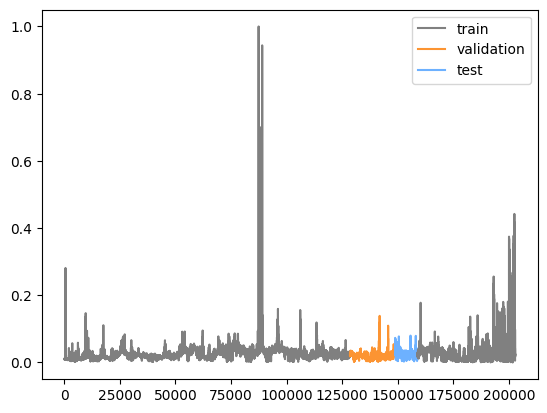

In [320]:
print(y_train.shape)
plt.plot(np.arange(0,val_end-val_size), y_train[0:val_end-val_size], color='grey', label='train')
plt.plot(np.arange(val_end-y_val.shape[0], val_end), y_val, color='#fc9432', label='validation')
plt.plot(np.arange(test_end-y_test.shape[0], test_end), y_test, color='#6db1ff', label='test')
plt.plot(np.arange(test_end,(test_end + y_train[val_end-val_size:].shape[0])), y_train[val_end-val_size:], color='grey')
plt.legend()

In [321]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, None, n_features), stateful=True),
    tf.keras.layers.Dense(1)
])


In [322]:

def compile_and_fit(model, X_train, y_train, X_val, y_val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  model.reset_states()
  # print(model.summary())
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=batch_size, verbose=1,
                      callbacks=[early_stopping])
  return history

# Data Analysis functions

feature_cutoff: Plot and calculate data cutoff based on mae impact

In [323]:
def feature_cutoff(df, baseline_mae, n_cols, iteration, cutoff = 0, prime = 0):
    # DISPLAY LSTM FEATURE IMPORTANCE
    df = pd.read_csv(iteration + '_feature_importance.csv', header=None, names=['feature','mae'])
    df = df.sort_values('mae')

    plt.figure(figsize=(10,20))
    plt.barh(np.arange(n_cols + 1),df.mae, color='#6db1ff')
    plt.yticks(np.arange(n_cols + 1),df.feature.values)
    plt.title('LSTM Feature Importance',size=16)
    plt.ylim((-1,n_cols + 1))

    plt.plot([baseline_mae,baseline_mae],[-1,n_cols + 1], '--', color='orange',
                label=f'Baseline \nMAE={baseline_mae:.4f}')
    a_set_columns = [] 
    b_set_columns = []
    prime_set_columns = []

    df = df[df.feature != 'Baseline']

    if cutoff != 0:
        if cutoff == 1:
            cutoff = np.std(df).mae
        a_set_columns = df[df['mae'] >= baseline_mae - cutoff].feature
        b_set_columns = df[df['mae'] < baseline_mae - cutoff].feature
        plt.plot([baseline_mae-cutoff,baseline_mae-cutoff],[-1,n_cols+1], '--', color='red',
                    label=f'Cutoff threshold\nMAE={baseline_mae-cutoff:.4f}')

    if prime != 0:
        if prime == 1:
            prime = np.std(df).mae
        prime_set_columns = df[df['mae'] > baseline_mae + cutoff].feature
        plt.plot([baseline_mae+cutoff,baseline_mae+cutoff],[-1,n_cols], '--', color='green',
                    label=f'Cutoff threshold\nMAE={baseline_mae+cutoff:.4f}')

    plt.xlabel(f'MAE with feature zeroed',size=14)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()

    return a_set_columns, b_set_columns, prime_set_columns

boxplot: Create a boxplot

In [324]:
def boxplot(data, columns):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, columns.shape[0]//6))

    meds = data.median()
    meds.sort_values(ascending=False, inplace=True)
    data = data[meds.index]

    # rectangular box plot
    bplot1 = ax1.boxplot(data,
                        vert=False,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=columns)  # will be used to label x-ticks

    for patch in bplot1['boxes']:
        patch.set_facecolor('#6db1ff')
    plt.show()

feature_importance: Calculate feature importance

In [325]:
import os
def feature_importance(model, X, y, df, batch_size, iteration):
    COLS = list(df.columns[1:])
    n_cols = len(COLS)
    # n_cols = 5
    print('Computing LSTM feature importance...')

    oof_preds = model.predict(X, verbose=0, batch_size=batch_size).squeeze() 
    baseline_mae = np.mean(np.abs( oof_preds-y ))
    print(baseline_mae)
    if not os.path.exists(iteration + '_feature_importance.csv'):
        results = []
        results.append({'feature':'BASELINE','mae':baseline_mae})           
        fi_df = pd.DataFrame(['Baseline', baseline_mae]).T
        fi_df.to_csv(iteration + '_feature_importance.csv', index=False, header=False)
        for k in range(n_cols):
            save_col = X[:,:,k].copy()
            X[:,:,k] = np.zeros((X.shape[0],X.shape[1]))
                    
            oof_preds = model.predict(X, verbose=0, batch_size=batch_size).squeeze() 
            mae = np.mean(np.abs( oof_preds-y ))
            # results.append({'feature':COLS[k],'mae':mae})
            fi_df = pd.DataFrame([COLS[k], mae]).T
            fi_df.to_csv(iteration + '_feature_importance.csv', mode='a', index=False, header=False)
            X[:,:,k] = save_col
    
    return baseline_mae, n_cols


# Zeroing feature importance 

In [326]:
history = compile_and_fit(model, X_train, y_train, X_val, y_val)

Epoch 1/2
1347/1347 [==============================] - 11s 7ms/step - loss: 6.2381e-04 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0250 - val_loss: 9.8358e-05 - val_mean_absolute_error: 0.0084 - val_root_mean_squared_error: 0.0099
Epoch 2/2
1347/1347 [==============================] - 9s 7ms/step - loss: 3.4754e-04 - mean_absolute_error: 0.0093 - root_mean_squared_error: 0.0186 - val_loss: 1.1428e-04 - val_mean_absolute_error: 0.0092 - val_root_mean_squared_error: 0.0107


Computing LSTM feature importance...
0.00917191184509591
19
(20,)


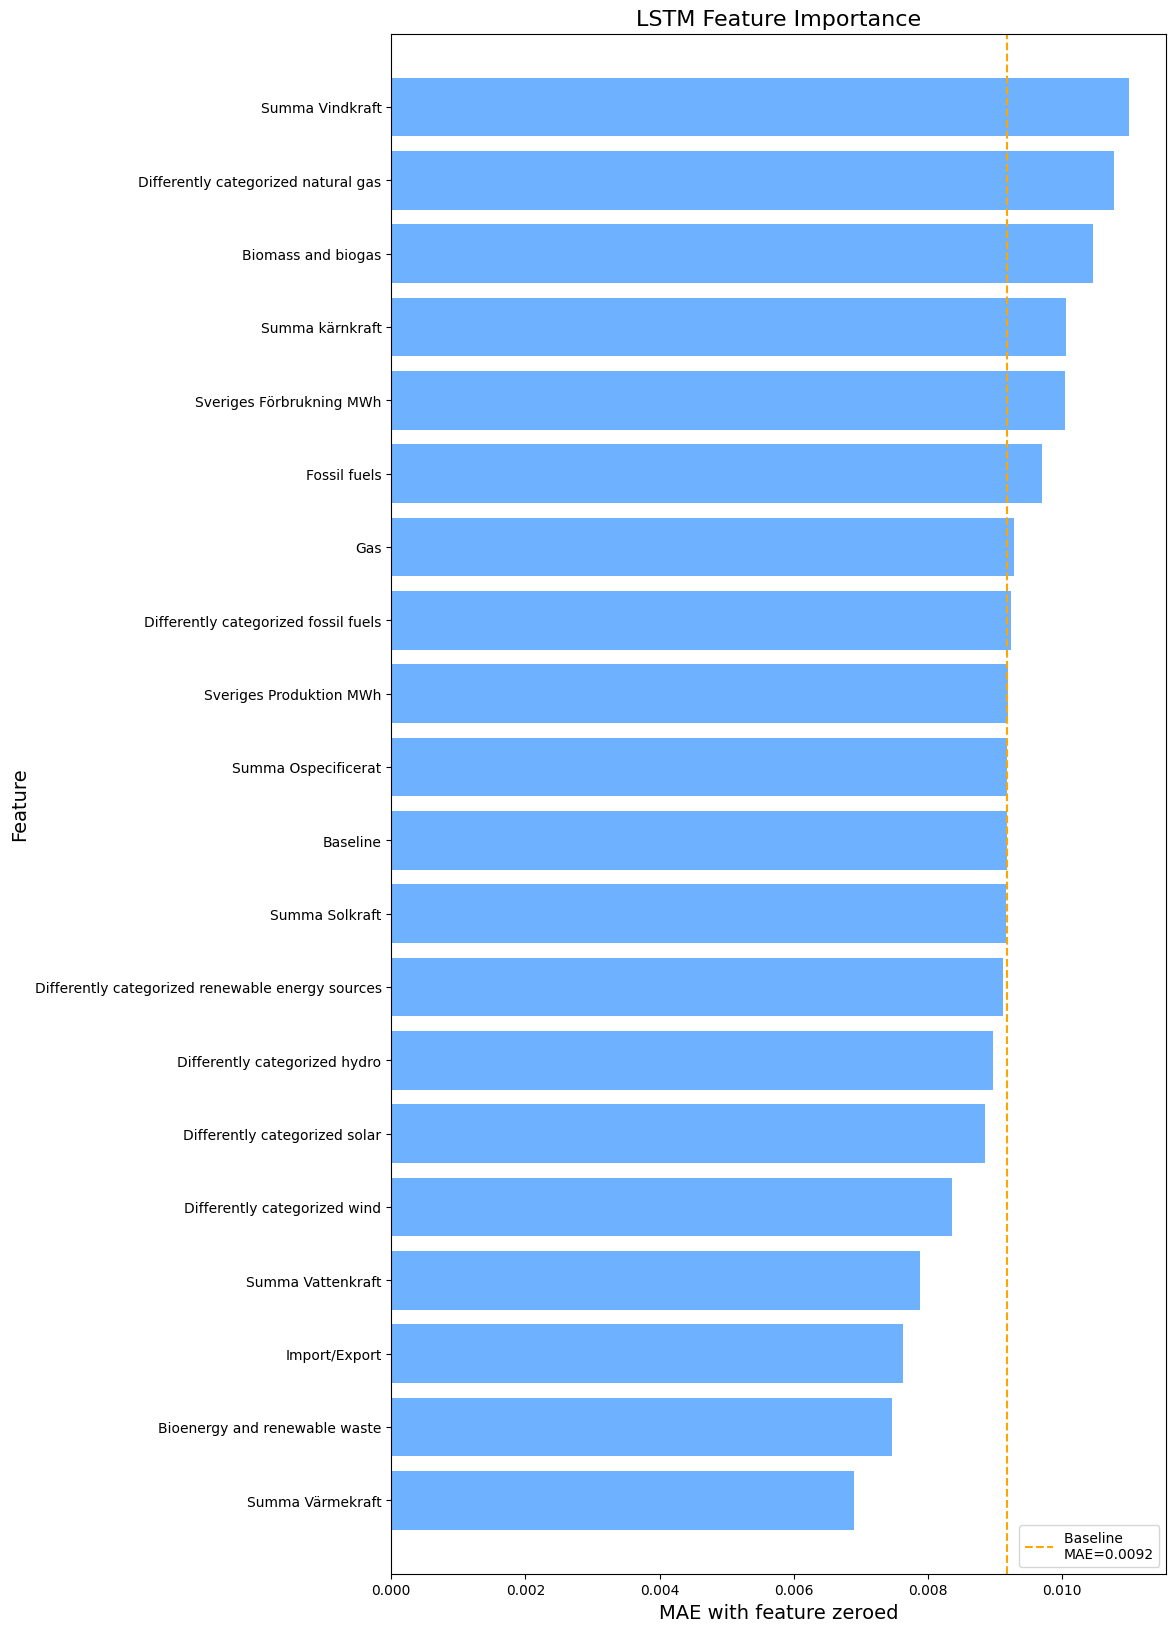

([], [], [])

In [327]:
baseline_mae, n_cols = feature_importance(model, X_val, y_val, df, batch_size, 'ZFI')
feature_cutoff(df, baseline_mae, n_cols, 'ZFI', cutoff = 0, prime = 0)

# Drop feature importance

In [328]:

COLS = list(df.columns[1:])
n_cols = len(COLS)
print(n_cols)
print('Computing LSTM feature importance...')

oof_preds = model.predict(X_val, verbose=0, batch_size=batch_size).squeeze() 
baseline_mae = np.mean(np.abs( oof_preds-y_val ))
# if not os.path.exists('DFI_feature_importance.csv'):
results = []
results.append({'feature':'BASELINE','mae':baseline_mae})           
fi_df = pd.DataFrame(['Baseline', baseline_mae]).T
fi_df.to_csv('DFI_feature_importance.csv', index=False, header=False)

model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, None, n_features), stateful=True),
    tf.keras.layers.Dense(1)
])

for k in range(n_cols):
    print("#################### Feature", COLS[k], "####################"))
    Xt = np.delete(X_train, k, axis=2)
    Xv = np.delete(X_val, k, axis=2)
    history = compile_and_fit(model2, Xt, y_train, Xv, y_val)
            
    oof_preds = model2.predict(Xv, verbose=0, batch_size=batch_size).squeeze() 
    mae = np.mean(np.abs( oof_preds-y_val ))
    # results.append({'feature':COLS[k],'mae':mae})
    fi_df = pd.DataFrame([COLS[k], mae]).T
    fi_df.to_csv('DFI_feature_importance.csv', mode='a', index=False, header=False)
  
    print(X_val.shape)

19
Computing LSTM feature importance...
Epoch 1/2
1347/1347 [==============================] - 11s 7ms/step - loss: 5.8512e-04 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0242 - val_loss: 9.8657e-05 - val_mean_absolute_error: 0.0084 - val_root_mean_squared_error: 0.0099
Epoch 2/2
1347/1347 [==============================] - 9s 7ms/step - loss: 3.4602e-04 - mean_absolute_error: 0.0093 - root_mean_squared_error: 0.0186 - val_loss: 1.0512e-04 - val_mean_absolute_error: 0.0087 - val_root_mean_squared_error: 0.0103
(20224, 1, 19)
Epoch 1/2
1347/1347 [==============================] - 11s 7ms/step - loss: 3.3743e-04 - mean_absolute_error: 0.0090 - root_mean_squared_error: 0.0184 - val_loss: 8.7389e-05 - val_mean_absolute_error: 0.0078 - val_root_mean_squared_error: 0.0093
Epoch 2/2
1347/1347 [==============================] - 9s 7ms/step - loss: 3.3079e-04 - mean_absolute_error: 0.0088 - root_mean_squared_error: 0.0182 - val_loss: 8.0225e-05 - val_mean_absolute_error: 0.0073 -